In [1]:
import os
import json
import jax
import copy
import jax.numpy as jnp
import netket as nk
import netket.jax as nkjax
from jax.tree_util import tree_map
from netket.vqs import FullSumState
# import netket_pro as nkp
import matplotlib.pyplot as plt

from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate
from grad_sample.tasks.fullsum_train import Trainer
from grad_sample.utils.tree_op import shape_tree


ImportError: cannot import name 'statistics' from 'advanced_drivers.driver' (/mnt/beegfs/home/CPHT/antoine.misery/netket_pro/packages/advanced_drivers/driver.py)

In [2]:
# import pubchempy as pcp
# from pyscf import gto, scf, fci, cc, mcscf

# # 1. Load the N2 molecule from PubChem (3D structure)
# cid = 947  # N2 molecule
# cid = 166630 #li20
# try:
#     compound = pcp.get_compounds(cid, "cid", record_type='3d')[0]
#     geom = '3d'
# except : 
#     compound = pcp.get_compounds(cid, "cid", record_type='2d')[0]
#     geom = '2d'
# name = cid
# # 2. Extract atomic coordinates
# geometry = []

# for atom in compound.atoms:
#     symbol = atom.element
#     if geom == '3d':
#         x, y, z  = atom.x, atom.y, atom.z
#     elif geom == '2d':
#         x, y, z  = atom.x, atom.y, 0.0
#     geometry.append(f"{symbol} {x} {y} {z}")

# # Convert to PySCF format
# mol_geometry = "\n".join(geometry)

# # 3. Define the molecule in PySCF
# mol = gto.Mole()
# mol.atom = mol_geometry
# mol.basis = "STO-3G"  # Choose a reasonable basis set
# mol.unit = "angstrom"  # Coordinates are in Ångströms
# mol.spin = 0  # N2 is a singlet
# mol.charge = 0
# mol.build()

# # 4. Run Hartree-Fock calculation
# mf = scf.RHF(mol)
# mf.kernel()
# mycc = mf.CISD().run()
# # 5. Compute Full Configuration Interaction (FCI) energy
# # cisolver = fci.FCI(mol, mf.mo_coeff)
# # E0 = cisolver.kernel()[0]

# # Print results
# print(f"Hartree-Fock Energy: {mf.e_tot:.6f} Ha")
# # print(f"FCI Ground State Energy: {E0:.6f} Ha")

In [3]:
# from netket import experimental as nkx
# import numpy as np
# mo_coeff = mf.mo_coeff
# E_nuc, Tij, Vijkl = nkx.operator.pyscf.TV_from_pyscf_molecule(mol, mo_coeff=mo_coeff)

# No = Tij.shape[0]//2
# Tij = Tij.todense()
# Tij_up = Tij[:No, :No]
# Tij_down = Tij[No:, No:]
# T_tot = jnp.abs(Tij_up) + jnp.abs(Tij_down)
# T_tot_od = jnp.abs(T_tot-jnp.diag(jnp.diagonal(T_tot)))
# adj_mat = jnp.abs(T_tot_od) >= 1e-5

# Vijkl = Vijkl.todense()
# # i = np.arange(Vijkl.shape[0])
# # Vijkl[:, :, i, i] = 0

# Vt = np.zeros((2*No, 2*No))
# for i in range(2*No):
#     for j in range(2*No):
#         Vt = Vt + np.abs(Vijkl[i,:,j])

# Vt = np.zeros((2*No, 2*No))
# for i in range(2*No):
#     Vt = Vt + np.abs(Vijkl[i,:,i,:])
# Vt_od = jnp.abs(Vt-jnp.diag(jnp.diagonal(Vt)))
# Vt2 = Vt_od[:No, :No]+Vt_od[No:, No:]

In [4]:
# import networkx as nx
# import jax.numpy as jnp  # Assuming you're using JAX for T_tot and Vt2

# # Compute the combined adjacency matrix based on the condition
# combined_adjacency = (Vt2 + T_tot) > 0
# # Remove diagonal (self-loops)
# combined_adjacency = combined_adjacency.at[jnp.diag_indices_from(combined_adjacency)].set(0)

# # Step 2: Convert to NumPy
# adj_matrix = np.array(combined_adjacency).astype(int)
# print(adj_matrix)
# num_nodes = adj_matrix.shape[0]
# # for i in range(num_nodes - 1):
# #     adj_matrix[i, i+1] = 1
# #     adj_matrix[i+1, i] = 1  # Ensure symmetry

# # Create a NetworkX graph from the adjacency matrix
# G = nx.from_numpy_array(adj_matrix)
# components = list(nx.connected_components(G))
# medians = []

# for comp in components:
#     sorted_nodes = sorted(comp)
#     median_idx = len(sorted_nodes) // 2
#     median_node = sorted_nodes[median_idx]
#     medians.append(median_node)

# # Step 5: Sort medians
# medians.sort()
# print(medians)
# # Step 6: Add edges between consecutive medians to connect components
# for i in range(len(medians) - 1):
#     G.add_edge(medians[i], medians[i + 1])
# # Optional: Draw the graph (requires matplotlib)
# import matplotlib.pyplot as plt

# nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
# plt.show()

In [5]:
# import numpy as np
# import igraph as ig
# import matplotlib.pyplot as plt
# import networkx as nx
# # Parameters
# N = 2*No
# cutoff = 0 # Only include edges with weight > cutoff

# # 2. Reshape into 2D: rows = (i,j), columns = (k,l)
# V_2d = Vijkl.reshape(N*N, N*N)

# # Create (i,j) index pairs and labels
# index_pairs = [(i, j) for i in range(N) for j in range(N)]
# labels = [f"{i}{j}" for (i, j) in index_pairs]

# # Build undirected graph
# G = nx.Graph()
# G.add_nodes_from(range(len(index_pairs)))  # nodes are 0, 1, ..., N*N - 1

# threshold = cutoff

# # Add edges based on threshold and symmetry
# added = set()
# for idx1, (i, j) in enumerate(index_pairs):
#     for idx2, (k, l) in enumerate(index_pairs):
#         if (i, j) == (k, l):
#             continue
#         if (idx2, idx1) in added:  # avoid duplicating undirected edges
#             continue

#         weight = V_2d[idx1, idx2]
#         if weight > threshold:
#             G.add_edge(idx1, idx2, weight=weight)
#             added.add((idx1, idx2))

# # Plotting
# plt.figure(figsize=(8, 6))

# disconnected = list(nx.isolates(G))
# G.remove_nodes_from(disconnected)
# pos = nx.spring_layout(G, seed=42)
# edge_weights = [2 * G[u][v]['weight'] for u, v in G.edges()]

# label_dict = {i: labels[i] for i in list(pos.keys())}

# nx.draw_networkx_nodes(G, pos, node_size=30, node_color='lightblue')
# nx.draw_networkx_edges(G, pos, width=1, edge_color='black', alpha=1)

# nx.draw_networkx_labels(G, pos, labels=label_dict, font_size=3)

# plt.title("Undirected NetworkX Graph from $V_{ijkl}$", fontsize=14)
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('net.pdf')
# plt.show()

In [6]:
# jnp.sum(np.diagonal(jnp.abs(V_2d)))

In [7]:
# plt.hist(jnp.abs(V_2d).flatten(),bins=np.logspace(-12, np.log10(np.max(jnp.abs(V_2d))),100))
# plt.yscale('log')
# plt.xscale('log')

In [8]:
# len(np.where(V_2d.flatten() > 0)[0]) / len(V_2d.flatten())

In [9]:
# # 6. Plot graph
# layout = g.layout("kk")
# fig, ax = plt.subplots(figsize=(8, 6))
# ig.plot(
#     g,
#     target=ax,
#     layout=layout,
#     vertex_label=g.vs['label'],
#     edge_width=[2 * w for w in weights],
#     edge_color="gray",
#     vertex_color="lightblue",
#     vertex_size=12,
#     vertex_label_size=9,
# )
# plt.title(f"igraph from V_{{ijkl}} (cutoff = {cutoff})")
# plt.show()

In [10]:
# #plt.imshow(jnp.abs(Vijkl.reshape(400,400)))
# adj_mat_2 = adj_mat + (np.abs(Vt2)>1e-2)

In [11]:
# import igraph as i
# g = ig.Graph.Adjacency((adj_mat_2 > 0).tolist(), mode=ig.ADJ_UNDIRECTED)

# # Optional: add vertex labels
# g.vs["label"] = list(range(len(adj_mat_2)))

# # Plot it
# layout = g.layout("kk")  # Kamada-Kawai layout
# fig, ax = plt.subplots()
# ig.plot(
#     g,
#     target=ax,
#     layout=layout,
#     vertex_size=30,
#     vertex_label=g.vs["label"],
#     vertex_color="skyblue",
#     edge_color="gray"
# )
# plt.title("Graph from Adjacency Matrix (igraph)")
# plt.show()

In [12]:
out_state = {}
def save_state_rel_err(step, logdata, driver, e_gs):
    for k in range(1,6):
        if jnp.abs(jnp.abs(driver._loss_stats.mean.real-e_gs)/jnp.abs(e_gs) - 10**(-k)) < 10**(-k-1):
            out_state[k] = {}
            out_state[k]['vars'] = driver.state.variables
            out_state[k]['rel_err'] = jnp.abs(driver._loss_stats.mean.real-e_gs)/jnp.abs(e_gs)
    return True

In [13]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate

if GlobalHydra().is_initialized():
    GlobalHydra().clear()
with initialize(version_base=None, config_path="./grad_sample/conf/"):
    cfg = compose(config_name="qchem_fs")
    OmegaConf.set_struct(cfg, True)
    print(cfg)
    print(type(cfg.task))
    # cfg = OmegaConf.to_yaml(cfg)
    # take any task from cfg and run it
trainer = Trainer(cfg)
    
# # global initialization
# initialize(version_base=None, config_path="conf", job_name="test_app")
# cfg = compose(config_name="config", overrides=["db=mysql", "db.user=me"])
# print(OmegaConf.to_yaml(cfg))

{'device': None, 'auto_is': True, 'lr': 'schedule', 'diag_shift': 0.0002, 'n_iter': 500, 'sample_size': 0, 'chunk_size_jac': 1024, 'chunk_size_vmap': 100, 'save_every': None, 'run_index': None, 'base_path': '/qchem_fs/', 'model': {'_target_': 'grad_sample.models.qchem.PCMolecule', 'cid': 947, 'use_nat_orb': False}, 'ansatz': {'_target_': 'grad_sample.ansatz.nnbf.LogNeuralBackflow', 'n_layers': 2, 'hidden_units': 16}, 'task': {'_target_': 'grad_sample.tasks.fullsum_train.Trainer'}, 'solver_fn': {'_target_': 'netket.optimizer.solver.cholesky'}, 'sampler': {'_target_': 'netket.sampler.ExactSampler'}, 'is_distrib': {'_target_': 'advanced_drivers.driver.overdispersed_distribution', 'alpha': 0.8}}
<class 'omegaconf.dictconfig.DictConfig'>
converged SCF energy = -107.498967544584
E(RCISD) = -107.6470818557084  E_corr = -0.1481143111245236
E(CCSD) = -107.6560799970224  E_corr = -0.1571124524385704
converged SCF energy = -107.498967544584


/mnt/beegfs/workdir/antoine.misery/mambaforge/envs/netket/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


scratch folder not specified in env variables
Nparams = 3360
/mnt/beegfs/workdir/antoine.misery/qchem_fs//947_0/L20/NNBF/16/schedule_0.0002/run_14
creating driver
finished creating driver


In [14]:
from functools import partial
save_state_cb = partial(save_state_rel_err, e_gs=trainer.E_gs)
trainer.gs.run(n_iter=500, callback=(save_state_cb,))

  0%|                  | 0/500 [00:00<?, ?it/s]

2025-06-23 15:49:43.776905: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2025-06-23 15:49:43.776984: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2025-06-23 15:49:43.809428: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2025-06-23 15:49:43.809478: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse 

KeyboardInterrupt: 

In [15]:
jnp.abs(trainer.gs._loss_stats.mean.real-trainer.E_gs)/jnp.abs(trainer.E_gs)

Array(1.82775732e-06, dtype=float64)

In [16]:
out_state.keys()

dict_keys([2, 4, 5])

In [17]:
def kl_dist(p1, p2):
    p1 = p1 / jnp.sum(p1)
    p2 = p2 / jnp.sum(p2)
    return jnp.sum(p1 * jnp.log(p1/p2))

In [32]:
def get_kl_snr_rel_err(vars):
    fs_state = FullSumState(hilbert = trainer.gs.state.hilbert, model = trainer.gs.state.model, chunk_size=None, seed=0)
    fs_state.variables = copy.deepcopy(vars)
    pdf = fs_state.probability_distribution()
    vstate_arr = fs_state.to_array()
    Hloc = trainer.gs._ham @ vstate_arr / vstate_arr
    Hloc_c = (Hloc - jnp.sum(Hloc*pdf))

    mode = "complex"
    # uncentered jacobian
    jacobian_orig = nkjax.jacobian(
        fs_state._apply_fun,
        fs_state.parameters,
        fs_state.hilbert.all_states(), #in MC state, this is vstate.samples
        fs_state.model_state,
        pdf=pdf,
        mode=mode,
        dense=True,
        center=False,
        chunk_size=10,
        _sqrt_rescale=False, #(not) rescaled by sqrt[π(x)], but in MC this rescales by 1/sqrt[N_mc]
    )

    # (#ns, 2) -> (#ns*2)
    Hloc_2 = jnp.stack([jnp.real(Hloc_c), jnp.imag(Hloc_c)], axis=-1)
    Hloc_c = jax.lax.collapse(Hloc_2, 0, 2)
    jacobian_orig_c = jacobian_orig - jnp.sum(jacobian_orig*jnp.expand_dims(pdf, range(len(jacobian_orig.shape))[1:]),axis=0)
    jacobian_orig_c = jax.lax.collapse(jacobian_orig_c, 0, 2)
    loc_grad_v = jacobian_orig_c.T * Hloc_c
    loc_grad_v = loc_grad_v[:, ::2] + loc_grad_v[:, 1::2]
    loc_grad_c = loc_grad_v - jnp.sum(pdf * loc_grad_v, axis=-1)[:,None]
    mean_grad = jnp.sum(jnp.abs(pdf * loc_grad_c), axis=0)/ jnp.sum(jnp.abs(pdf * loc_grad_c))

    alpha = 1
    mod_pdf = jnp.abs(vstate_arr)**alpha/jnp.sum(jnp.abs(vstate_arr)**alpha)
    # loc_grad_c = jnp.abs(loc_grad_v - jnp.mean(loc_grad_v, axis=1)[:,None])
    # mean_grad = jnp.sum(jnp.abs(pdf * loc_grad_c), axis=0)/ jnp.sum(jnp.abs(pdf * loc_grad_c))
    mean_grad_unc = jnp.sum(jnp.abs(pdf * loc_grad_v), axis=0) / jnp.sum(jnp.abs(pdf * loc_grad_v))
    # plt.plot(mod_1_pdf)
    # plt.yscale('log')
    def mod_pdf_fun(alpha):
        return (jnp.abs(vstate_arr)**alpha)/jnp.sum(jnp.abs(vstate_arr)**alpha)

    def unnorm_pdf(alpha):
        return (jnp.abs(vstate_arr)**alpha)
    
    def compute_snr_is(q):
        # compute variance of gradient from global variables and specified pdf
        q_pdf = q / jnp.sum(q)
        w_mean = jnp.sum(q_pdf * unnorm_pdf(2.0)/q)
        v = jnp.sum(q_pdf * (unnorm_pdf(2.0)/q)**2 * jnp.abs(loc_grad_v - jnp.sum(pdf * loc_grad_v, axis=1)[:, None])**2, axis=1)/(w_mean**2)
        return jnp.mean(jnp.abs(jnp.sum(pdf * loc_grad_v, axis = 1)) / jnp.sqrt(v))
    
    def compute_ess(q):
        q_pdf = q / jnp.sum(q)
        w = (q_pdf * (unnorm_pdf(2.0)/(q_pdf*jnp.sum(unnorm_pdf(2.0))))**2)
        
        return 1/jnp.sum(w)
                        
    def compute_bias_is(q):
        q_pdf = q / jnp.sum(q)
        w = (unnorm_pdf(2.0)/q)
        w_mean = jnp.sum(q_pdf * w) # $\mu_W$
        w_n = w / w_mean
        mu_X = jnp.sum(q_pdf * w * loc_grad_v, axis = 1)
        # print(mu_X.shape)
        term_1 = jnp.sum(q_pdf * w_n**2) - 1 #compute the ess like term, variance of w
        # print(term_1.shape)
        term_2 = jnp.sum(q_pdf * (w_n - 1) * (loc_grad_v - mu_X[:, None]), axis = 1)#covariance of X and W
    
        # term_1 = jnp.sum(q_pdf * w * loc_grad_v, axis = 1) #compute the ess like term, variance of w
        mean_factor = jnp.mean(term_1[None] - term_2)
        # rel_abs_bias = jnp.abs(mu * jnp.sum(q_pdf * w**2 * (mu[:,None] - loc_grad_v), axis=1)/jnp.sum(pdf * loc_grad_v, axis=1))
        
        return mean_factor
    
    alphas = jnp.linspace(0,2,100)
    kl_grad = [kl_dist(mod_pdf_fun(a), mean_grad_unc) for a in alphas]
    kl_grad_c = [kl_dist(mod_pdf_fun(a), mean_grad) for a in alphas]
    snr_alpha = [compute_snr_is(unnorm_pdf(a)) for a in alphas]
    bias_alpha = [compute_bias_is(unnorm_pdf(a)) for a in alphas]
    print(bias_alpha[-1])
    return alphas, kl_grad, kl_grad_c, snr_alpha, bias_alpha

0.009875415620104617
0.0
9.706715355856682e-05
-4.440892098500626e-16
9.541043571579747e-06
4.440892098500626e-16


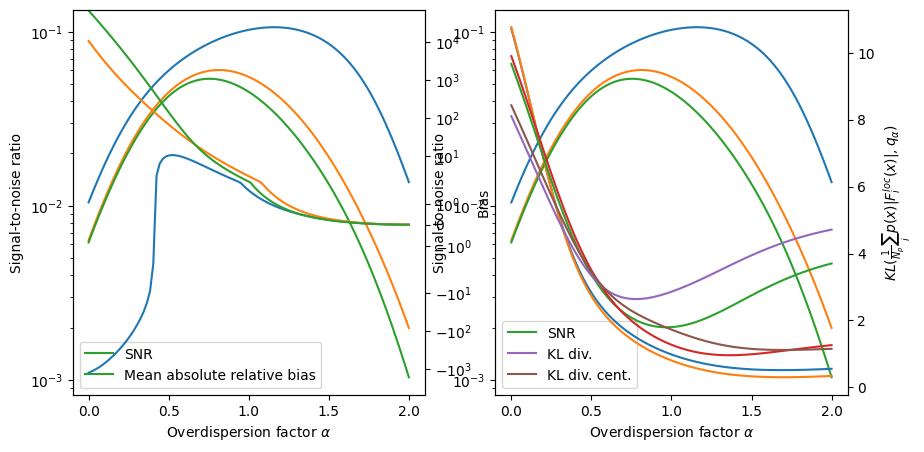

In [33]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
ax1  = axes[0].twinx()
ax11 = axes[1].twinx()

for k in list(out_state.keys()):
    vars, rel_err = out_state[k]['vars'], out_state[k]['rel_err']
    print(rel_err)
    alphas, kl_grad, kl_grad_c, snr_alpha, bias_alpha = get_kl_snr_rel_err(vars)
    axes[0].plot(alphas, snr_alpha, label = 'SNR')
    ax1.plot(alphas, bias_alpha, label = 'Mean absolute relative bias')
    axes[1].plot(alphas, snr_alpha, label = 'SNR')
    ax11.plot(alphas, kl_grad, label = 'KL div.')
    ax11.plot(alphas, kl_grad_c, label = 'KL div. cent.')
    
axes[0].set_xlabel(r'Overdispersion factor $\alpha$')
ax1.set_ylabel(r'Bias')
axes[0].set_ylabel(r"Signal-to-noise ratio")
axes[0].set_yscale('log')
ax1.set_yscale('symlog')
axes[1].set_xlabel(r'Overdispersion factor $\alpha$')
ax11.set_ylabel(r'$KL(\frac{1}{N_p}\sum_i p(x)|F_i^{loc}(x)|, q_\alpha)$')
axes[1].set_ylabel(r"Signal-to-noise ratio")
axes[1].set_yscale('log')

# Collect handles and labels from both axes
handles, labels = [], []
for a in [axes[0], ax1]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates by using a dictionary
unique = dict(zip(labels, handles))
# axes[0].legend(ncol=2, loc='upper right', fontsize=14)
axes[0].legend(unique.values(), unique.keys())

# Collect handles and labels from both axes
handles, labels = [], []
for a in [axes[1], ax11]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates by using a dictionary
unique = dict(zip(labels, handles))
# axes[0].legend(ncol=2, loc='upper right', fontsize=14)
axes[1].legend(unique.values(), unique.keys())

In [8]:
# bias_alpha = [compute_bias_is(unnorm_pdf(a)) for a in jnp.linspace(0,2,100)]

In [34]:
out_dict = {
    'alphas': alphas,
    'kl_grad' : kl_grad,
    'kl_grad_c' : kl_grad_c,
    'snr_alpha' : snr_alpha,
    'bias_alpha' : bias_alpha
}
# jnp.savez('snr_bias_kl.npz', **out_dict)

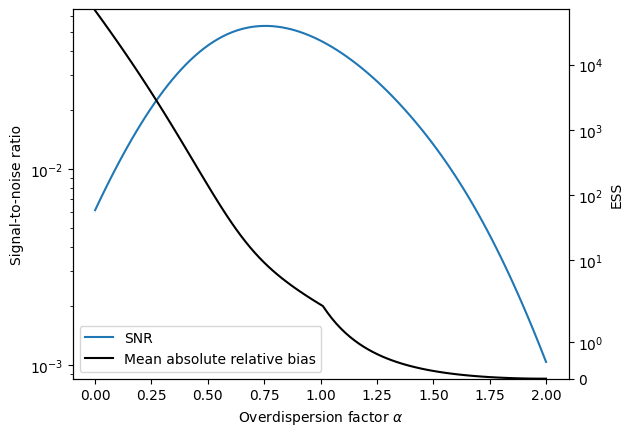

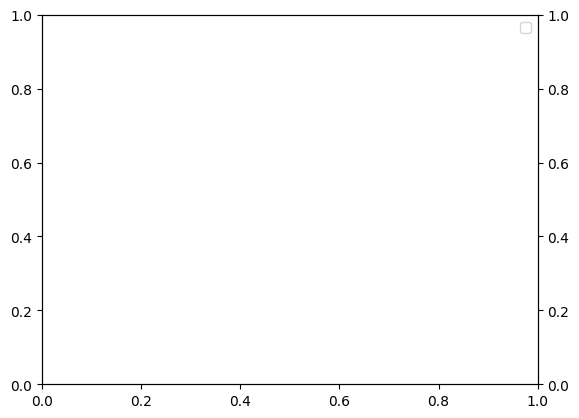

In [40]:
fig, ax = plt.subplots()
ax1  =ax.twinx()
ax.plot(alphas, snr_alpha, label = 'SNR')
ax1.plot(alphas, bias_alpha, color='black', label = 'Mean absolute relative bias')

ax.set_xlabel(r'Overdispersion factor $\alpha$')
ax1.set_ylabel(r'ESS')
ax.set_ylabel(r"Signal-to-noise ratio")
ax.set_yscale('log')
ax1.set_yscale('symlog')
ax1.set_ylim(bottom=-1e-3)
# Collect handles and labels from both axes
handles, labels = [], []
for a in [ax, ax1]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates by using a dictionary
unique = dict(zip(labels, handles))
# axes[0].legend(ncol=2, loc='upper right', fontsize=14)
ax.legend(unique.values(), unique.keys())
fig, ax = plt.subplots()
ax1  =ax.twinx()



# Collect handles and labels from both axes
handles, labels = [], []
for a in [ax, ax1]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates by using a dictionary
unique = dict(zip(labels, handles))
# axes[0].legend(ncol=2, loc='upper right', fontsize=14)
ax.legend(unique.values(), unique.keys())

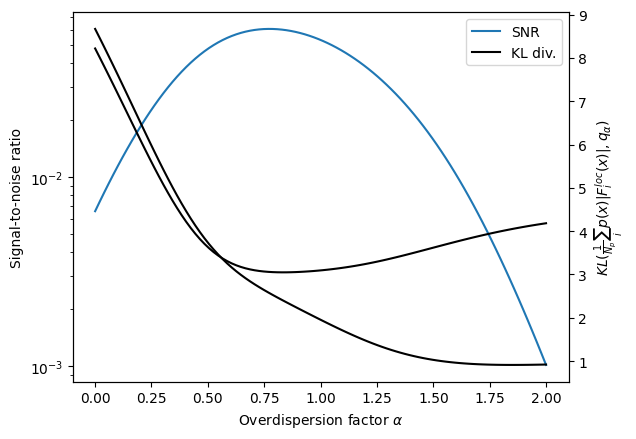

In [77]:
fig, ax = plt.subplots()
ax1  =ax.twinx()
ax.plot(alphas, snr_alpha, label = 'SNR')
ax1.plot(alphas, kl_grad, color='black', label = 'KL div.')
ax1.plot(alphas, kl_grad_c, color='black', label = 'KL div.')

ax.set_xlabel(r'Overdispersion factor $\alpha$')
ax1.set_ylabel(r'$KL(\frac{1}{N_p}\sum_i p(x)|F_i^{loc}(x)|, q_\alpha)$')
ax.set_ylabel(r"Signal-to-noise ratio")
ax.set_yscale('log')
# Collect handles and labels from both axes
handles, labels = [], []
for a in [ax, ax1]:
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates by using a dictionary
unique = dict(zip(labels, handles))
# axes[0].legend(ncol=2, loc='upper right', fontsize=14)
ax.legend(unique.values(), unique.keys())